# Intructor Infections

In [2]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
import ray
import shapley
sys.path.append('../')

In [131]:
class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0

def exists_pos_in_class(frac_vax, N, params = class_risk_params):
    num_vax = np.floor(N*frac_vax)
    num_unvax = N-num_vax

    prev_unvax = params['prevalence']
    prev_vax = prev_unvax * (1-params['vax_effectiveness'])

    p_pos_unvax = prev_unvax * (1-params['sensitivity'])
    p_pos_vax = prev_vax * (1-params['sensitivity'])

    prob_exists_positive = 1 - (1-p_pos_unvax)**num_unvax * (1-p_pos_vax)**num_vax
    prob_one_positive = num_unvax * p_pos_unvax * (1-p_pos_unvax)**(num_unvax-1) * (1-p_pos_vax)**num_vax + \
                      (1-p_pos_unvax)**num_unvax * num_vax * p_pos_vax * (1-p_pos_vax)**(num_vax-1)
    approx_error = prob_exists_positive - prob_one_positive

    return prob_exists_positive, prob_one_positive, approx_error*N


def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time,alpha,masked_status,class_type,room_vol,N,pixels_per_foot):
    room = room.reset_index()
    
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    
    
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    unvax_aerosol_risk = 0.5*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params)
    x = 1100
    y = 1750
    dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
    susceptible_status = 'U'
    p = updated_distance_to_prob(dist,susceptible_status,source_status,masked_status,time,pixels_per_foot)
    unvax_droplet_risk = max(p,0)
    
    return unvax_droplet_risk,unvax_aerosol_risk

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time,pixels_per_foot): 
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const = 1
    if susceptible_status == 'V':
        susceptible_const = 1 - class_risk_params['vax_effectiveness'] 
    if source_status == 'V':
        source_const = 0.29 
    if masked_status == True:
        masked_const = 0.8
        
    prob = 2.4*susceptible_const*(1-np.exp(-1 * source_const* masked_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params):
    
    if class_type == 'breathe':
        v = params['nominal_breathe_virus_emitted_hourly'] 
    elif class_type == 'speak':
        v = params['nominal_talk_virus_emitted_hourly'] 
    elif class_type == 'sing':
        v = params['nominal_sing_virus_emitted_hourly'] 
    
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])

  # variables: source vaccinated? susceptible vaccinated? susceptible masked?
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    if masked_status == 1:
        dose_array = dose_array * 0.8
    if vax_infected == 1:
        dose_array = dose_array * 0.29 
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)

    #vax_susceptible_risk_array = (1 - class_risk_params['vax_effectiveness']) * unvax_susceptible_risk_array
    #susceptible_risk_array = unvax_susceptible_risk_array * (1-frac_vax) + vax_susceptible_risk_array * frac_vax
    #susceptible_risk = np.dot(susceptible_risk_array, np.array(params['viral_load_distribution']))
    #individual_susceptible_risk_over_time = 2.4*susceptible_risk * time
    
    unvax_susceptible_risk = np.dot(unvax_susceptible_risk_array, np.array(params['viral_load_distribution']))
    unvax_susceptible_risk_over_time = 2.4*unvax_susceptible_risk * time

    return unvax_susceptible_risk_over_time

In [132]:
def generate_clumpy_plan(N,p,room, clump_size = 3):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Load Room Plans

([], [])

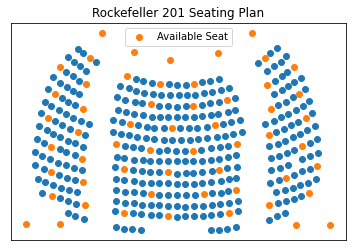

In [133]:
# Big Room
with open("../Data/rk201.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

big_pixels_per_foot = (2074-1575)/20
big_volume = 1684283

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']



FA2020room = room.copy()
FA2020room['label'] = FA2020room.index

#label of seats used in 2020
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Rockefeller 201 Seating Plan')
FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
big_plan = FA2020_subset.copy()
plt.legend()
plt.xticks([])
plt.yticks([])
#print([big_pixels_per_foot,big_volume,big_plan])

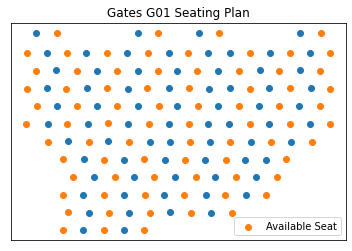

In [134]:
with open("../Data/gtsg01.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

medium_pixels_per_foot = (2834-2082)/20
medium_volume = 1087931

x_coord = [-i.x +3000 for i in layout['Middles']]
y_coord = [-i.y +3000 for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']
room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
medium_plan = room_subset.copy()

plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'])
plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Gates G01 Seating Plan')
plt.xticks([])
plt.yticks([])
plt.legend()

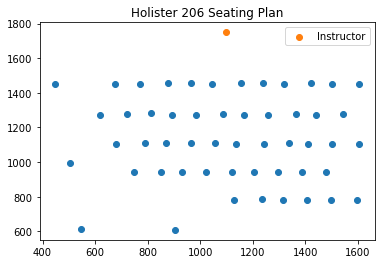

In [135]:
# Small Room
with open("../Data/hls206.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

small_pixels_per_foot = (2014-1260)/15
small_volume = 222004

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']


small_plan = room.copy()
small_plan['instructor'] = False
small_plan = small_plan.append({'x':1100,'y':1750, 'UnvaxSpot':1, 'instructor':True}, ignore_index = True)

plt.figure()
plt.scatter(small_plan[small_plan['instructor'] == 0]['x'],small_plan[small_plan['instructor'] == 0]['y'])
plt.scatter(small_plan[small_plan['instructor'] == 1]['x'],small_plan[small_plan['instructor'] == 1]['y'],  label = 'Instructor')
plt.title('Holister 206 Seating Plan')
plt.legend()
plt.xticks()
plt.yticks()
small_plan = room.copy()

#print([small_pixels_per_foot,small_volume,small_plan])

V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64
V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64


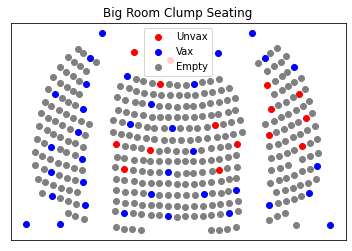

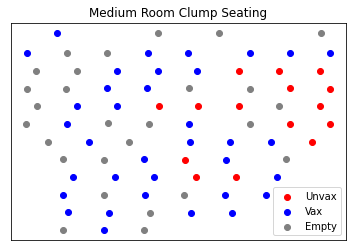

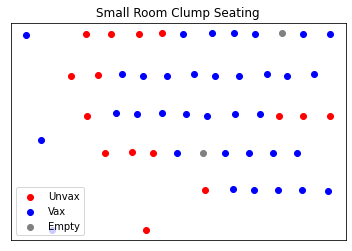

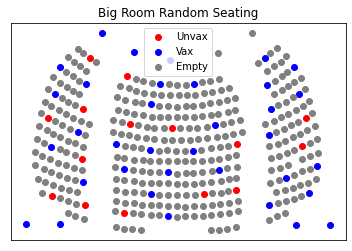

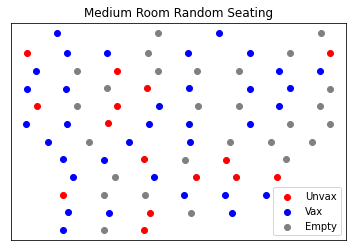

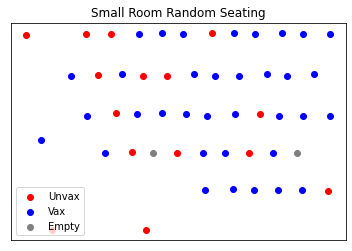

In [136]:
grid = generate_clumpy_plan(50,.7,big_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_clumpy_plan(50,.7,medium_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())


grid = generate_clumpy_plan(50,.7,small_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,big_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,medium_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,small_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

In [137]:
VE  = class_risk_params['vax_effectiveness']

# FWS simulation

In [138]:
@ray.remote
def parallel_wrapper(p):
    trial = 0
    results = []
    results_aerosol = []
    while trial < 500:
        grid = seating_function(N,p,room)
        p_generate = (1-class_risk_params['vax_effectiveness'])*p/(1-class_risk_params['vax_effectiveness']*p)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        
        infect,aerosol = simulate_class_single_aerosol(grid,ind, 1-ind, time,15,masked_status,class_type,room_vol,N,pixels_per_foot)
        results.append(infect)
        results_aerosol.append(aerosol)
        trial = trial + 1
    return [p,np.mean(results), np.mean(results_aerosol)]

In [159]:
#General Parameters
seating_function = generate_clumpy_plan
p_range = [0.7,0.75,0.8,0.85,0.9,0.95,1.0]
N = 50
time = 1
#Arguments
#[masked_status, room, room_vol,pixels_per_foot,class_type,label]
args = [[True, small_plan, small_volume, small_pixels_per_foot, 'breathe', 'mask_small_speak'],
[False, small_plan, small_volume, small_pixels_per_foot, 'breathe', 'nomask_small_speak']]

aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' :  27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

import warnings
warnings.filterwarnings("ignore")
final_results_FWS = {}
for arg in args:
    print(arg[-1])
    masked_status = arg[0]
    room = arg[1]
    room_vol = arg[2]
    pixels_per_foot = arg[3]
    class_type = arg[4]
    label = arg[5]
    
    ray.shutdown()
    ray.init(log_to_driver=False)
    result_ids = []
    for p in p_range:
        result_ids.append(parallel_wrapper.remote(p))    
    results = ray.get(result_ids)  
    ray.shutdown()
    results = pd.DataFrame(results, columns = ['p','unvax_droplet','unvax_aerosol'])
    final_results_FWS[label] = results

mask_small_speak


2021-08-11 12:08:50,294	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_small_speak


2021-08-11 12:09:06,227	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [160]:
final_results_FWS

{'mask_small_speak':       p  unvax_droplet  unvax_aerosol
 0  0.70       0.001092       0.000347
 1  0.75       0.001001       0.000314
 2  0.80       0.000915       0.000287
 3  0.85       0.000806       0.000254
 4  0.90       0.000680       0.000220
 5  0.95       0.000556       0.000189
 6  1.00       0.000425       0.000137,
 'nomask_small_speak':       p  unvax_droplet  unvax_aerosol
 0  0.70       0.001272       0.000419
 1  0.75       0.001190       0.000386
 2  0.80       0.001078       0.000358
 3  0.85       0.001057       0.000345
 4  0.90       0.001002       0.000292
 5  0.95       0.000709       0.000232
 6  1.00       0.000517       0.000171}

Text(0.5, 1.0, 'Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, 1 Student Speaking')

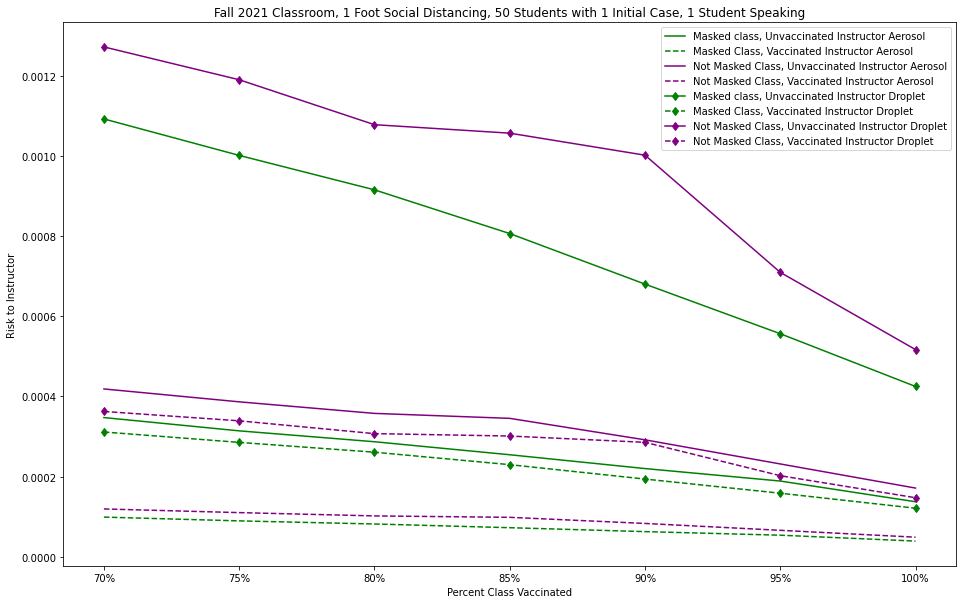

In [161]:
mark = 'd'
mask_small_speak = final_results_FWS['mask_small_speak']
nomask_small_speak = final_results_FWS['nomask_small_speak']
mask_small_speak['vax_aerosol'] = mask_small_speak['unvax_aerosol']*(1- VE)
nomask_small_speak['vax_aerosol'] = nomask_small_speak['unvax_aerosol']*(1- VE)

mask_small_speak['vax_droplet'] = mask_small_speak['unvax_droplet']*(1- VE)
nomask_small_speak['vax_droplet'] = nomask_small_speak['unvax_droplet']*(1- VE)


plt.figure(figsize = (16,10))
plt.plot(mask_small_speak['p'],mask_small_speak['unvax_aerosol'], label = 'Masked class, Unvaccinated Instructor Aerosol', color = 'green')
plt.plot(mask_small_speak['p'],mask_small_speak['vax_aerosol'], label = 'Masked Class, Vaccinated Instructor Aerosol', color = 'green', linestyle = 'dashed')
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor Aerosol', color = 'purple')
plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_aerosol'], label = 'Not Masked Class, Vaccinated Instructor Aerosol', color = 'purple', linestyle = 'dashed')


plt.plot(mask_small_speak['p'],mask_small_speak['unvax_droplet'], label = 'Masked class, Unvaccinated Instructor Droplet', color = 'green',marker = mark)
plt.plot(mask_small_speak['p'],mask_small_speak['vax_droplet'], label = 'Masked Class, Vaccinated Instructor Droplet', color = 'green', linestyle = 'dashed',marker = mark)
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_droplet'], label = 'Not Masked Class, Unvaccinated Instructor Droplet', color = 'purple',marker = mark)
plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_droplet'], label = 'Not Masked Class, Vaccinated Instructor Droplet', color = 'purple', linestyle = 'dashed',marker = mark)




plt.xlabel('Percent Class Vaccinated')
plt.xticks(ticks = [.7,.75,.8,.85,.9,.95,1], labels = [ '70%','75%', '80%','85%','90%','95%','100%'])
plt.legend()
plt.ylabel('Risk to Instructor')
plt.title('Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, 1 Student Speaking')

In [162]:
mask_small_speak['vax_total'] = mask_small_speak['vax_aerosol']+mask_small_speak['vax_droplet']
mask_small_speak['unvax_total'] = mask_small_speak['unvax_aerosol']+mask_small_speak['unvax_droplet']

nomask_small_speak['vax_total'] = nomask_small_speak['vax_aerosol']+nomask_small_speak['vax_droplet']
nomask_small_speak['unvax_total'] = nomask_small_speak['unvax_aerosol']+nomask_small_speak['unvax_droplet']


Text(0.5, 1.0, 'Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Lecture Class')

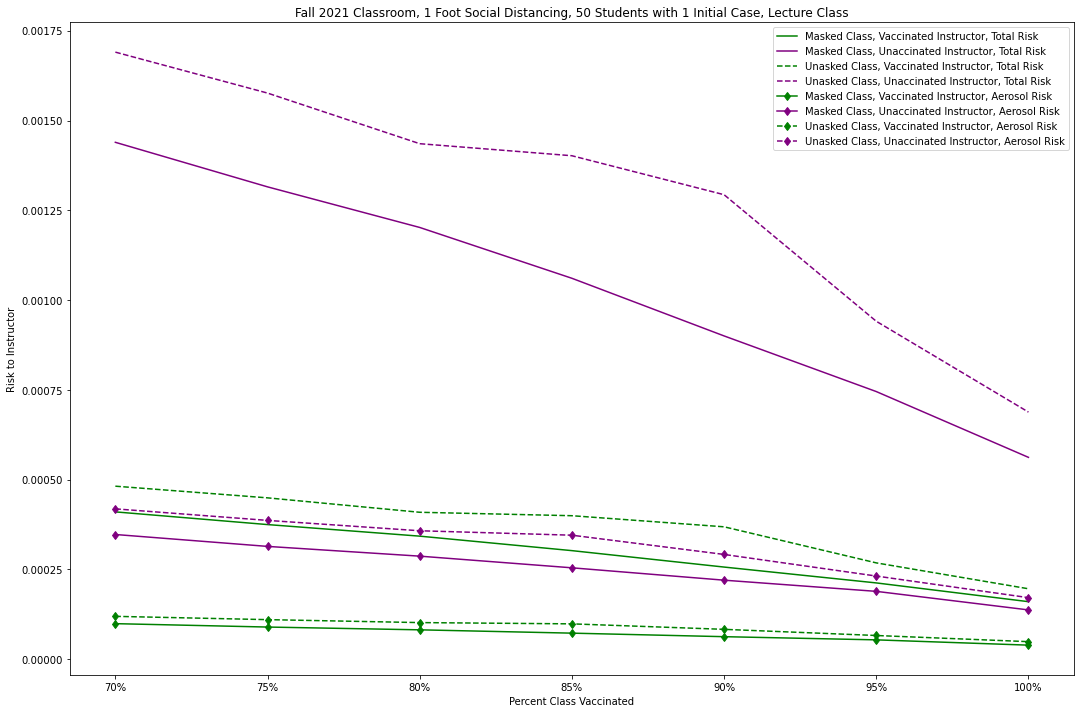

In [163]:
mark = 'd'
plt.figure(figsize = (18,12))

plt.plot(mask_small_speak['p'],mask_small_speak['vax_total'], label = 'Masked Class, Vaccinated Instructor, Total Risk', color = 'green')
plt.plot(mask_small_speak['p'],mask_small_speak['unvax_total'], label = 'Masked Class, Unaccinated Instructor, Total Risk', color = 'purple')

plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_total'], label = 'Unasked Class, Vaccinated Instructor, Total Risk', color = 'green', linestyle = 'dashed')
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_total'], label = 'Unasked Class, Unaccinated Instructor, Total Risk', color = 'purple', linestyle = 'dashed')


plt.plot(mask_small_speak['p'],mask_small_speak['vax_aerosol'], label = 'Masked Class, Vaccinated Instructor, Aerosol Risk', color = 'green', marker = mark)
plt.plot(mask_small_speak['p'],mask_small_speak['unvax_aerosol'], label = 'Masked Class, Unaccinated Instructor, Aerosol Risk', color = 'purple', marker = mark)

plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_aerosol'], label = 'Unasked Class, Vaccinated Instructor, Aerosol Risk', color = 'green', linestyle = 'dashed', marker = mark)
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_aerosol'], label = 'Unasked Class, Unaccinated Instructor, Aerosol Risk', color = 'purple', linestyle = 'dashed', marker = mark)



plt.xlabel('Percent Class Vaccinated')
plt.xticks(ticks = [.7,.75,.8,.85,.9,.95,1], labels = [ '70%','75%', '80%','85%','90%','95%','100%'])
plt.legend()
plt.ylabel('Risk to Instructor')
plt.title('Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Lecture Class')


In [29]:
nomask_small_speak.to_csv('sim_results/instructor_1ft_distance_1_speak_10_students_FWS.csv')

# Results Values